# BERT fine-tuning 文本分类

In [2]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(transformers.__version__)

2.0.0+cu118
4.40.2


In [4]:
import matplotlib as mpl
# default: 100
mpl.rcParams['figure.dpi'] = 200   # 分辨率调整

# text classification

- 也叫 sequence classification
- sentiment analysis
    - 情感分析，就是一种文本/序列分类
        - 电商评论
        - social web：weibo/tweet

## emotions 数据集

In [5]:
from datasets import load_dataset

In [6]:
emotions = load_dataset('emotion')

/root/miniconda3/lib/python3.8/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
# DatasetDict
# 8:1:1
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
emotions.keys()

dict_keys(['train', 'validation', 'test'])

In [9]:
print(emotions['train'], type(emotions['train']))
print('=================================')
# 继续支持 key
print(emotions['train']['text'][:5])
print(emotions['train']['label'][:5])
print('=================================')
# 支持 index
print(emotions['train'][:5])

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
}) <class 'datasets.arrow_dataset.Dataset'>
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 3, 2, 3]
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(emotions['train'].features)
print(emotions['train'].features['label'])
print(emotions['train'].features['label'].int2str(3))

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
anger


In [11]:
labels = emotions['train'].features['label'].names
print(labels)

# 下游任务（downstream task）
num_classes = len(labels)
num_classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


6

## data visualization analysis

- dataset => dataframe
- text length 
- label freq

### dataset to dataframe

In [12]:
emotions_df = pd.DataFrame.from_dict(emotions['train'])

In [13]:
print(emotions_df.shape, emotions_df.columns)
emotions_df[:5]

(16000, 2) Index(['text', 'label'], dtype='object')


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
# emotions_df['label_name'] = emotions_df['label'].apply(lambda x: emotions['train'].features['label'].int2str(x))
emotions_df['label_name'] = emotions_df['label'].apply(lambda x: labels[x])
emotions_df[:5]

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### label analysis

In [15]:
emotions_df.label.value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

In [16]:
emotions_df.label_name.value_counts()

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Text(0.5, 1.0, 'freq of labels')

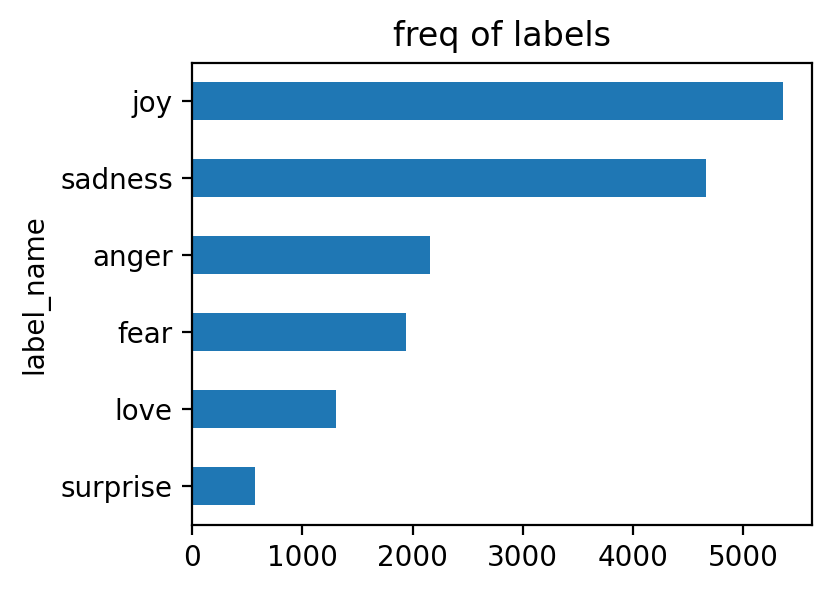

In [17]:
plt.figure(figsize=(4, 3))
emotions_df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('freq of labels')

### text length analysis

Text(0.5, 0, '')

<Figure size 800x600 with 0 Axes>

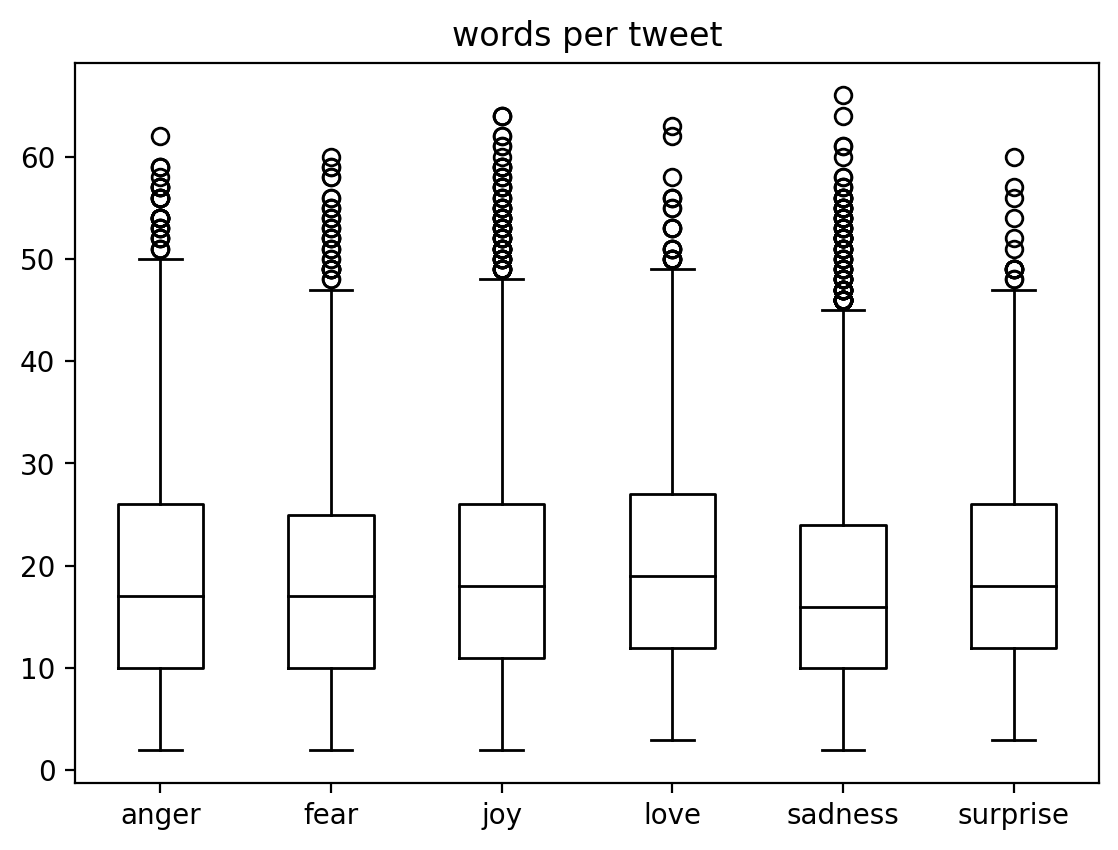

In [18]:
plt.figure(figsize=(4, 3))
emotions_df['words per tweet'] = emotions_df['text'].str.split().apply(len)
emotions_df.boxplot('words per tweet', by='label_name', 
#                     showfliers=False, 
                    grid=False, 
                    color='black')
plt.suptitle('')
plt.xlabel('')

In [19]:
print(emotions_df['words per tweet'].max())
print(emotions_df['words per tweet'].idxmax())

66
6322


In [20]:
print(emotions_df.iloc[6322])
emotions_df.iloc[6322]['text']

text               i guess which meant or so i assume no photos n...
label                                                              0
label_name                                                   sadness
words per tweet                                                   66
Name: 6322, dtype: object


'i guess which meant or so i assume no photos no words or no other way to convey what it really feels unless you feels it yourself or khi bi t au th m i bi t th ng ng i b au i rephrase it to a bit more gloomy context unless you are hurt yourself you will never have sympathy for the hurt ones'

In [21]:
print(emotions_df['words per tweet'].min())
print(emotions_df['words per tweet'].idxmin())

2
4150


In [22]:
emotions_df.iloc[4150]

text               earth crake
label                        4
label_name                fear
words per tweet              2
Name: 4150, dtype: object

## text => tokens

数据集转换为模型接受的输入类型
- Subword Tokenization
    - WordPiece
        - BERT and DistilBERT
- hugging face:
    - `~/.cache/huggingface/`
- tokenizer
    - `tokenizer.vocab_size`
    - model config
        - `tokenizer.model_max_length`
        - `tokenizer.model_input_names`

### tokenizer

In [23]:
from transformers import AutoTokenizer

In [24]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/root/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
# uncased
print(tokenizer.encode('hello world'))
print(tokenizer.encode('HELLO WORLD'))
print(tokenizer.encode('Hello World'))

[101, 7592, 2088, 102]
[101, 7592, 2088, 102]
[101, 7592, 2088, 102]


In [26]:
# 101([CLS]) 开始，以 102 ([SEP]) 结束
tokenizer.encode(emotions_df.iloc[6322]['text'])

[101,
 1045,
 3984,
 2029,
 3214,
 2030,
 2061,
 1045,
 7868,
 2053,
 7760,
 2053,
 2616,
 2030,
 2053,
 2060,
 2126,
 2000,
 16636,
 2054,
 2009,
 2428,
 5683,
 4983,
 2017,
 5683,
 2009,
 4426,
 2030,
 1047,
 4048,
 12170,
 1056,
 8740,
 16215,
 1049,
 1045,
 12170,
 1056,
 16215,
 12835,
 12835,
 1045,
 1038,
 8740,
 1045,
 16360,
 13492,
 3366,
 2009,
 2000,
 1037,
 2978,
 2062,
 24067,
 2100,
 6123,
 4983,
 2017,
 2024,
 3480,
 4426,
 2017,
 2097,
 2196,
 2031,
 11883,
 2005,
 1996,
 3480,
 3924,
 102]

In [27]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [28]:
for special_id in tokenizer.all_special_ids:
    print(special_id, tokenizer.decode(special_id))

100 [UNK]
102 [SEP]
0 [PAD]
101 [CLS]
103 [MASK]


### tokenize the whole dataset

In [29]:
def batch_tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [30]:
# batch_tokenize(emotions['train'])
emotions_encoded = emotions.map(batch_tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [31]:
emotions_encoded   # 此时得到了 input_ids 和 attention_mask

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [32]:
print(type(emotions_encoded['train']['input_ids']))   # list of list
# emotions_encoded['train']['input_ids'][:3]

<class 'list'>


In [33]:
# list to tensor
emotions_encoded.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

In [34]:
type(emotions_encoded['train']['input_ids'])
# emotions_encoded['train']['input_ids'][:3]

torch.Tensor

# fine-tune transformers

## distilbert-base-uncased

- distilbert 是对 bert 的 distill 而来
    - 模型结构更为简单，
    - bert-base-uncased 参数量：109482240
    - distilbert-base-uncased 参数量：66362880

In [35]:
from transformers import AutoModel
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [36]:
from transformers_utils import get_params

In [37]:
get_params(model)

66362880

In [38]:
from transformers import AutoModel
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
get_params(model)

/root/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


109482240

In [39]:
109482240 / 66362880

1.6497511862053003

In [40]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [41]:
from transformers import AutoModelForSequenceClassification
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 可以通过 watch -n 1 nvidia-smi 命令查看前后的显存占用 （约需要 1G 的显存）
# model = AutoModelForSequenceClassification.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_classes).to(device)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## trainer

In [42]:
# https://huggingface.co/settings/tokens
# (write)
from huggingface_hub import notebook_login
notebook_login()

In [43]:
# https://huggingface.co/docs/transformers/main_classes/trainer
# https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
from transformers import TrainingArguments, Trainer

In [44]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}_emotion_ft_0416'
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=4, 
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # write
                                  push_to_hub=True, 
                                  log_level="error")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


- trainer默认自动开启 torch 的多gpu模式，
    - `per_device_train_batch_size`: 这里是设置每个gpu上的样本数量，
    - 一般来说，多gpu模式希望多个gpu的性能尽量接近，否则最终多gpu的速度由最慢的gpu决定，
        - 比如快gpu 跑一个batch需要5秒，跑10个batch 50秒，慢的gpu跑一个batch 500秒，则快gpu还要等慢gpu跑完一个batch然后一起更新weights，速度反而更慢了。
    - 同理 `per_device_eval_batch_size` 类似
- `learning_rate`/`weight_decay`
    - 默认使用AdamW的优化算法

In [45]:
from transformers_utils import compute_classification_metrics
trainer = Trainer(model=model, 
                  tokenizer=tokenizer,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  args=training_args, 
                  compute_metrics=compute_classification_metrics)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,0.789200,0.265811,0.914000,0.914295,0.881622
2,0.207900,0.169176,0.935000,0.935137,0.907387
3,0.140000,0.153715,0.938000,0.938587,0.902507
4,0.113000,0.147266,0.935000,0.934862,0.912192


TrainOutput(global_step=1000, training_loss=0.31251622581481936, metrics={'train_runtime': 178.055, 'train_samples_per_second': 359.439, 'train_steps_per_second': 5.616, 'total_flos': 1440685723392000.0, 'train_loss': 0.31251622581481936, 'epoch': 4.0})

In [47]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output

PredictionOutput(predictions=array([[ 5.5545692 , -0.8816876 , -1.1866075 , -1.2507623 , -1.4744883 ,
        -1.6881181 ],
       [ 5.5698895 , -0.8911641 , -1.7212515 , -1.0745    , -1.0046251 ,
        -1.722541  ],
       [-1.9029949 ,  2.4128237 ,  3.4573731 , -1.5554088 , -2.1262763 ,
        -1.9510471 ],
       ...,
       [-1.6577936 ,  5.7174    , -0.18278821, -1.5974994 , -2.1695194 ,
        -1.6114564 ],
       [-2.329563  ,  3.7387428 ,  2.7502978 , -1.7612374 , -2.2760775 ,
        -1.8738166 ],
       [-1.762956  ,  5.698456  , -0.7973222 , -1.8237401 , -1.9656497 ,
        -0.7869622 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.14726589620113373, 'test_accuracy': 0.935, 'test_f1': 0.9348624946265062, 'test_precision': 0.9121920305146612, 'test_runtime': 1.0313, 'test_samples_per_second': 1939.349, 'test_steps_per_second': 31.03})

In [48]:
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_preds

array([0, 0, 2, ..., 1, 1, 1])

In [49]:
y_true = emotions_encoded['validation']['label']
y_true

tensor([0, 0, 2,  ..., 1, 1, 1])

In [50]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

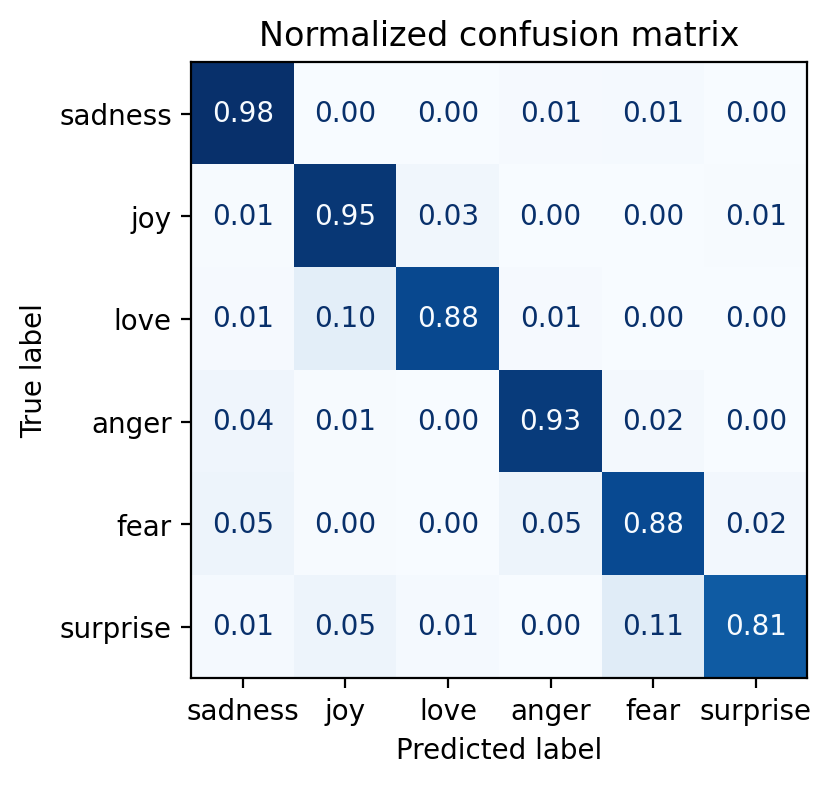

In [51]:
from transformers_utils import plot_confusion_matrix
plot_confusion_matrix(y_preds, y_true, labels)

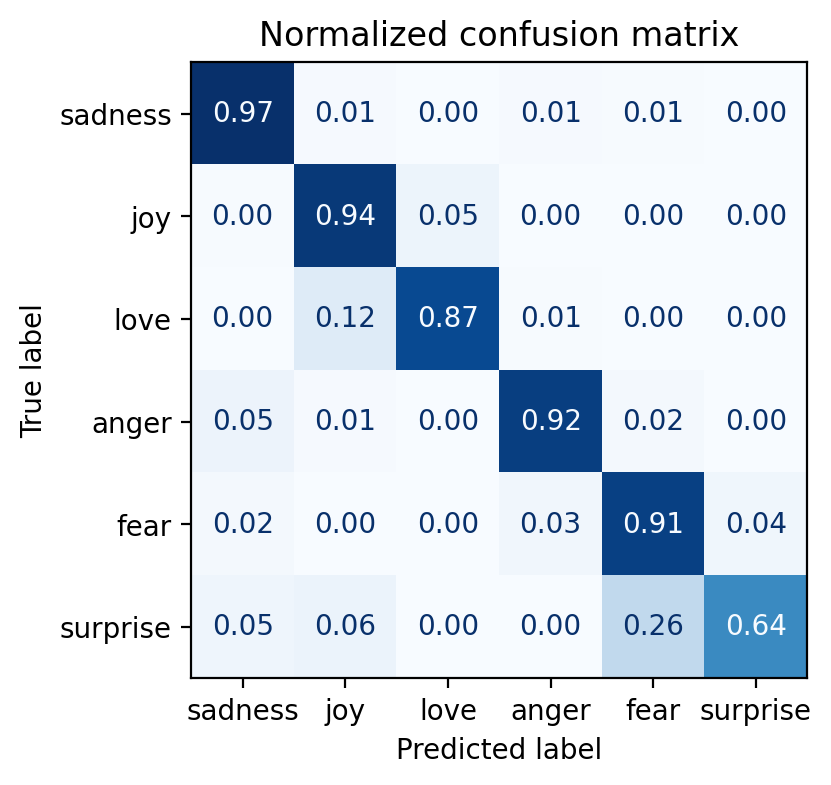

In [52]:
preds_output = trainer.predict(emotions_encoded["test"])
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = emotions_encoded["test"]['label']
plot_confusion_matrix(y_preds, y_true, labels)

# result analysis

In [53]:
from torch.nn.functional import cross_entropy

In [54]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [55]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
emotions_encoded['validation']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [57]:
selected_cols = ['text', 'label', 'predicted_label', 'loss']

In [58]:
valid_df = pd.DataFrame.from_dict({'text': emotions_encoded["validation"]['text'], 
                                   'label': emotions_encoded['validation']['label'].numpy(), 
                                   'pred_label': emotions_encoded['validation']['predicted_label'].numpy(), 
                                   'loss': emotions_encoded["validation"]['loss'].numpy()})
valid_df['label'] = valid_df['label'].apply(lambda x: labels[x])
valid_df['pred_label'] = valid_df['pred_label'].apply(lambda x: labels[x])

In [59]:
valid_df

,text,label,pred_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.005478
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.005606
2,i feel like a faithful servant,love,love,0.315861
3,i am just feeling cranky and blue,anger,anger,0.007504
4,i can have for a treat or if i am feeling festive,joy,joy,0.003621
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.006305
1996,i constantly worry about their fight against n...,joy,joy,0.004753
1997,i feel its important to share this info for th...,joy,joy,0.005050
1998,i truly feel that if you are passionate enough...,joy,joy,0.325448


In [60]:
valid_df[valid_df['label'] != valid_df['pred_label']]

,text,label,pred_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,2.606535
27,i feel as if i am the beloved preparing hersel...,joy,love,1.204820
35,i am feeling very blessed today that they shar...,joy,love,0.725992
55,i didn t feel accepted,joy,love,0.752656
60,i miss our talks our cuddling our kissing and ...,love,joy,0.845419
...,...,...,...,...
1958,i so desperately want to be able to help but i...,fear,sadness,1.223704
1963,i called myself pro life and voted for perry w...,joy,sadness,6.198002
1964,i feel vaguely cheated and a little amused,joy,anger,2.358922
1981,i spent a lot of time feeling overwhelmed with...,fear,surprise,0.807642


In [61]:
1 - 129 / 2000

0.9355

In [62]:
# most labels incorrectly
valid_df[valid_df['label'] != valid_df['pred_label']].label.value_counts()

label
joy         36
fear        26
love        21
anger       19
surprise    15
sadness     13
Name: count, dtype: int64

In [63]:
# 分类错误的 loss 均较大
valid_df.sort_values('loss', ascending=False).head(10)

,text,label,pred_label,loss
1111,im lazy my characters fall into categories of ...,joy,fear,6.511402
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.327398
882,i feel badly about reneging on my commitment t...,love,sadness,6.244055
1963,i called myself pro life and voted for perry w...,joy,sadness,6.198002
318,i felt ashamed of these feelings and was scare...,fear,sadness,6.193089
1950,i as representative of everything thats wrong ...,surprise,sadness,5.813737
405,i have been feeling extraordinarily indecisive...,fear,joy,5.684981
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.473402
415,im kind of embarrassed about feeling that way ...,love,joy,4.174177
1662,i did not directly react to the spot fixing co...,joy,anger,4.162587


In [64]:
# mislabeld
valid_df.iloc[882].text

'i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio'

In [65]:
# less loss means more confident
valid_df.sort_values('loss', ascending=True).head(10)

,text,label,pred_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.003338
1050,i feel like our society has programmed little ...,joy,joy,0.003377
669,i am not feeling very joyful today its been a ...,joy,joy,0.003464
1607,i feel incredibly mellow and spacey,joy,joy,0.003475
400,i are just relaxing together and i feel ecstat...,joy,joy,0.003526
620,i shall move right along to the post interview...,joy,joy,0.003535
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.003544
1199,i didn t feel ecstatic after each workout or a...,joy,joy,0.003547
632,i feel he is an terrific really worth bet,joy,joy,0.003604
199,i feel invigorated full of energy ready for th...,joy,joy,0.003606


# to huggingface hub

In [66]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/Nicho-k/distilbert-base-uncased_emotion_ft_0416/commit/7372e5c6d6379b657ef13f56bd6566fca98834e6', commit_message='Training completed!', commit_description='', oid='7372e5c6d6379b657ef13f56bd6566fca98834e6', pr_url=None, pr_revision=None, pr_num=None)

In [67]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "Nicho-k/distilbert-base-uncased_emotion_ft_0416"
classifier = pipeline("text-classification", model=model_id)

/root/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [68]:
custom_tweet = "I saw a movie today and it was really good."
# custom_tweet = "I saw a movie today and it suck."
preds = classifier(custom_tweet, return_all_scores=True)
preds

/root/miniconda3/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.008543752133846283},
  {'label': 'LABEL_1', 'score': 0.9793643355369568},
  {'label': 'LABEL_2', 'score': 0.0020592177752405405},
  {'label': 'LABEL_3', 'score': 0.0042535699903965},
  {'label': 'LABEL_4', 'score': 0.0023213166277855635},
  {'label': 'LABEL_5', 'score': 0.0034579052589833736}]]

In [69]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

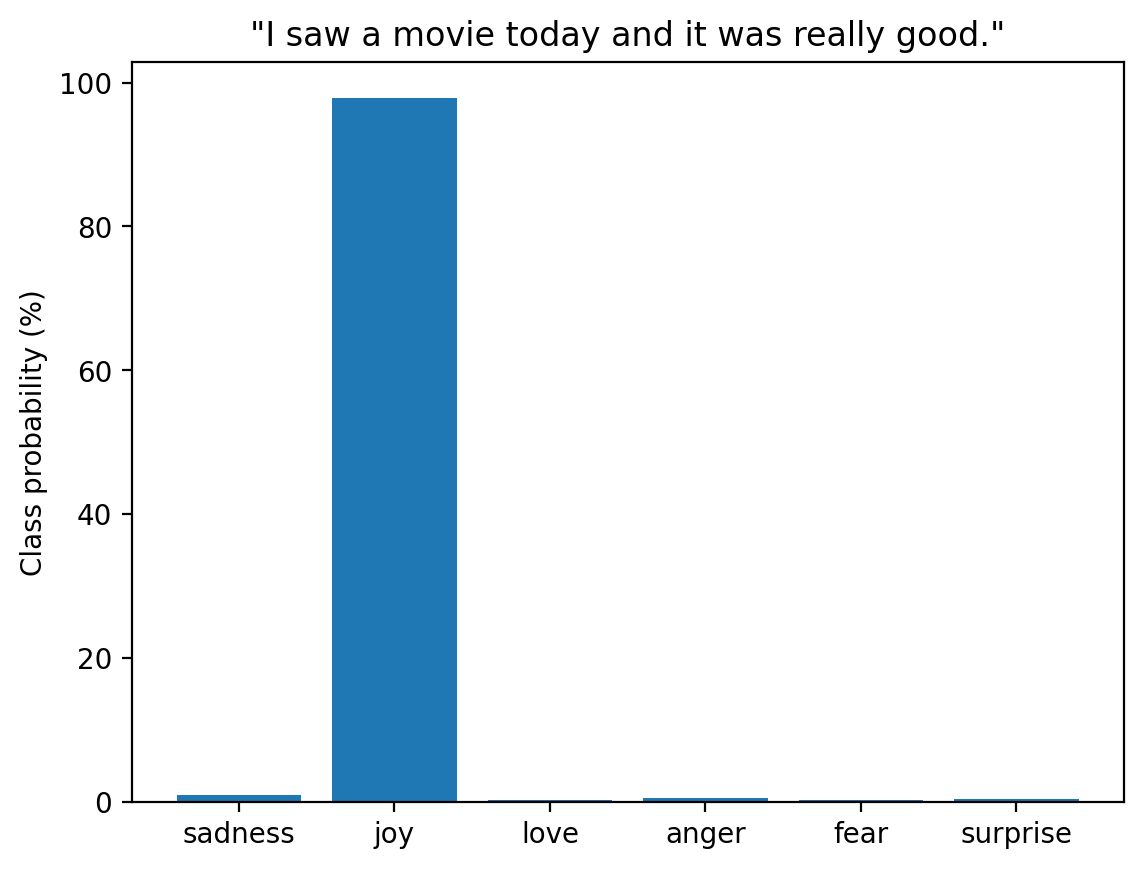

In [70]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()